In [1]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
from IPython.display import display
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [76]:
def plot_df(df, kind, x, y, xlabel, ylabel, color, title):
    
    plt.clf()
    
    # Define fig, ax
    fig, ax = plt.subplots(figsize=(12,4))
    fig.suptitle(title)
    # Make bar plot
    plot = df.plot(kind=kind, x=x, y=y, color=color, ax=ax, width=0.95)

    # Set labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.tick_params(axis='x', rotation=60, labelsize=8)
    
    # Set legend
    legend = plt.legend()
    frame = legend.get_frame()
    frame.set_facecolor('white')

    return plot

In [3]:
parent_dir = 'LIBRARIES'

In [4]:
def retrieve_tracklist(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    main_dict=root.findall('dict')
    for item in list(main_dict[0]):    
        if item.tag=="dict":
            tracks_dict=item
            break
    tracklist=list(tracks_dict.findall('dict'))
    
    return tracklist

In [5]:
def create_lists(tracklist):
    purchased=[] # All purchased music
    apple_music=[] # Music added to lirary through subscription
    for item in tracklist:
        x=list(item)
        for i in range(len(x)):
            if x[i].text=="Kind" and x[i+1].text=="File audio AAC acquistato":
                purchased.append(list(item)) 
            if x[i].text=="Kind" and x[i+1].text=="File audio AAC Apple Music":
                apple_music.append(list(item))
    return purchased, apple_music

In [6]:
def cols(kind):
    cols=[]
    for i in range(len(kind)):
        for j in range(len(kind[i])):
            if kind[i][j].tag=="key":
                cols.append(kind[i][j].text)
    return set(cols)

In [7]:
def df_creation(kind, cols):
    df = pd.DataFrame(columns=cols)
    df_list = []
    for row in kind:
        dict1 = {}
        for i in range(len(row) - 1):
            if row[i].tag == "key":
                dict1[row[i].text] = row[i+1].text
        if "Play Count" not in dict1:
            dict1["Play Count"] = 0
        list_values = [i for i in dict1.values()]
        list_keys = [j for j in dict1.keys()]
        df_temp = pd.DataFrame([list_values], columns=list_keys)
        df_list.append(df_temp)

    df = pd.concat(df_list, axis=0, ignore_index=True, sort=True)
    return df

In [8]:
columns_of_interest=['track_id','song_name','play_count','skip_count','album','artist' \
 ,'genre','kind','persistent_id','year_of_release','play_date','skip_date',\
 'release_date','date_modified']

In [9]:
# Initiliaze an empty list to hold the dataframes
df_list = []

# Loop through each folder
for folder in os.listdir(parent_dir):
    folder_path = os.path.join(parent_dir, folder)
    if os.path.isdir(folder_path):
        year = int(folder)
    
        # Loop through each file in the folder
        for file in os.listdir(folder_path):
            if file.startswith("music_library_"):
                month = int(file.split("_")[2][4:6])
                print(f"Reading {month}-{year} library file")
                file_path = os.path.join(folder_path, file)
    
                tracklist = retrieve_tracklist(file_path)
                
                # Create apple_music and purchased lists:
                purchased, apple_music = create_lists(tracklist)
                
                # Define columns:
                purchased_cols = cols(purchased)
                apple_music_cols = cols(apple_music)
                
                # Create Pandas Dataframe:
                df_purchased = df_creation(purchased,purchased_cols)
                df_apple_music = df_creation(apple_music,apple_music_cols)
                
                # Create a single dataframe for purchased and apple music songs:
                temp_apple = df_apple_music.loc[:,['Track ID','Name','Play Count','Skip Count','Album',\
                    'Artist','Genre','Kind','Persistent ID','Year','Play Date UTC',\
                    'Skip Date','Release Date','Date Modified']]
                temp_purchased = df_purchased.loc[:,['Track ID','Name','Play Count','Skip Count', \
                    'Album','Artist','Genre','Kind','Persistent ID','Year',\
                    'Play Date UTC','Skip Date','Release Date','Date Modified']]
                df_songs = pd.concat([temp_purchased,temp_apple],axis = 0)
                df_songs.columns = columns_of_interest
                
                # Cast columns to appropriate datatypes
                df_songs[['track_id','play_count','skip_count','year_of_release']] = df_songs[['track_id',\
                    'play_count','skip_count','year_of_release']].apply(pd.to_numeric)
                df_songs[['play_date','skip_date','release_date','date_modified']] = df_songs[['play_date',\
                    'skip_date','release_date','date_modified']].apply(pd.to_datetime)
                
                # Create a month and year column (corresponding to the specific photograph of the Library)
                df_songs['year_libr'] = year
                df_songs['month_libr'] = month
                
                # Append the dataframe to the list
                df_list.append(df_songs)
                
                
# Concatenate all the dataframes into a single dataframe
df_library_history = pd.concat(df_list, ignore_index=True)

Reading 2-2023 library file


In [10]:
df_library_history.head(10)

,track_id,song_name,play_count,skip_count,album,artist,genre,kind,persistent_id,year_of_release,play_date,skip_date,release_date,date_modified,year_libr,month_libr
0,2,Intro,31,36.0,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,26F5FAF6CA27A142,2017,2021-10-20 08:02:47+00:00,2021-10-07 10:09:22+00:00,2017-04-07 07:00:00+00:00,2017-04-06 21:15:44+00:00,2023,2
1,3,Tutti Matti (Aquadrop Remix),99,9.0,Tradimento 10 Anni - Reloaded,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,798DED70FD60F633,2006,2022-03-05 00:14:25+00:00,2022-02-18 23:42:57+00:00,2006-06-13 07:00:00+00:00,2016-07-02 07:56:52+00:00,2023,2
2,4,Red carpet,37,17.0,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,0AF1EA782BC1B4C4,2017,2021-10-20 08:06:23+00:00,2022-11-27 17:28:23+00:00,2017-04-07 07:00:00+00:00,2017-04-06 21:15:44+00:00,2023,2
3,5,Pamplona (feat. Thegiornalisti),73,48.0,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,8555A5C2D2F63C05,2017,2022-12-24 19:13:30+00:00,2022-12-04 17:34:43+00:00,2017-04-07 07:00:00+00:00,2017-04-06 21:15:44+00:00,2023,2
4,6,Skit - Il tempo vola,22,39.0,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,17880BA47A1D7B84,2017,2021-05-27 16:44:54+00:00,2021-10-20 08:09:51+00:00,2017-04-07 07:00:00+00:00,2017-04-06 21:15:44+00:00,2023,2
5,7,Fenomeno,23,39.0,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,D07C277271891E95,2017,2021-10-20 08:09:42+00:00,2023-01-05 10:18:11+00:00,2017-04-07 07:00:00+00:00,2017-04-06 22:15:44+00:00,2023,2
6,8,Dexter (feat. Nitro & Salmo),9,13.0,Squallor,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,76499C82CD64F711,2015,2021-02-13 11:22:00+00:00,NaT,2015-04-07 07:00:00+00:00,2015-04-11 12:19:45+00:00,2023,2
7,9,Equilibrio,82,10.0,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,9C3B4DEF5CB10904,2017,2022-09-23 17:49:55+00:00,2022-02-10 15:17:42+00:00,2017-04-07 07:00:00+00:00,2017-04-06 21:15:44+00:00,2023,2
8,10,Le vacanze (Big Fish Remix),7,9.0,Fenomeno (Masterchef EP),Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,21560D45DC7878EE,2017,2020-09-12 12:29:59+00:00,2019-04-30 05:41:41+00:00,2017-11-17 08:00:00+00:00,2017-11-17 20:06:33+00:00,2023,2
9,11,Skit - Considerazioni (feat. Roberto Saviano),17,27.0,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,2A5385851C474657,2017,2020-01-16 22:52:24+00:00,2020-09-24 12:56:20+00:00,2017-04-07 07:00:00+00:00,2017-04-06 21:15:44+00:00,2023,2


In [11]:
# Replacing different words for "Rap" genre with "Hip-Hop":
replacements = {'Hip Hop/Rap': 'Hip-Hop/Rap', 
                'Hip Hop': 'Hip-Hop/Rap',
                'Hip-Hop': 'Hip-Hop/Rap'
               
               }
df_library_history['genre'] = df_library_history['genre'].replace(replacements)

For further analysis, it may useful to have a dataframe listing just albums and corresponding artists:

In [54]:
# Find artist of each album
all_albums = df_month.groupby(['album', 'artist']).size().to_frame().reset_index()
all_albums = all_albums.rename(columns={0: 'song_count'})

all_albums = all_albums.loc[all_albums.groupby('album')['song_count'].idxmax()]
all_albums = all_albums[['album', 'artist']]
display(all_albums.head(10))

,album,artist
0,'A verità (Special Edition),Rocco Hunt
1,12000 Lune,Lucio Dalla
3,17,Emis Killa & Jake La Furia
9,1969 - Achille Idol Rebirth,Achille Lauro
10,20,Capo Plaza
11,21,Adele
12,23 6451,thasup
21,25,Adele
22,30,Adele
23,8 Mile (Music from and Inspired By the Motion ...,Eminem


## Historical Analysis

### Top Genre, Artist, Songs and Albums

In [12]:
# Time variable definition:
year_analysis = 2023
month_analysis = 2

In [13]:
# Filter dataframe
df_month = df_library_history[(df_library_history['year_libr']==year_analysis) & (df_library_history['month_libr']==2)]

In [74]:
# Genre exploration
df_genres_count = df_month.groupby('genre')['play_count'].sum().to_frame().reset_index()

top15_genre = df_genres_count.sort_values(by='play_count', ascending=False).head(15)
display(top15_genre)

,genre,play_count
6,Hip-Hop/Rap,13586
11,Pop,2118
2,Dance,456
13,R&B/Soul,255
0,Alternative,76
15,Rock,56
17,Soundtrack,40
7,Indie Pop,32
3,Electronic,27
8,J-Pop,24


<Figure size 640x480 with 0 Axes>

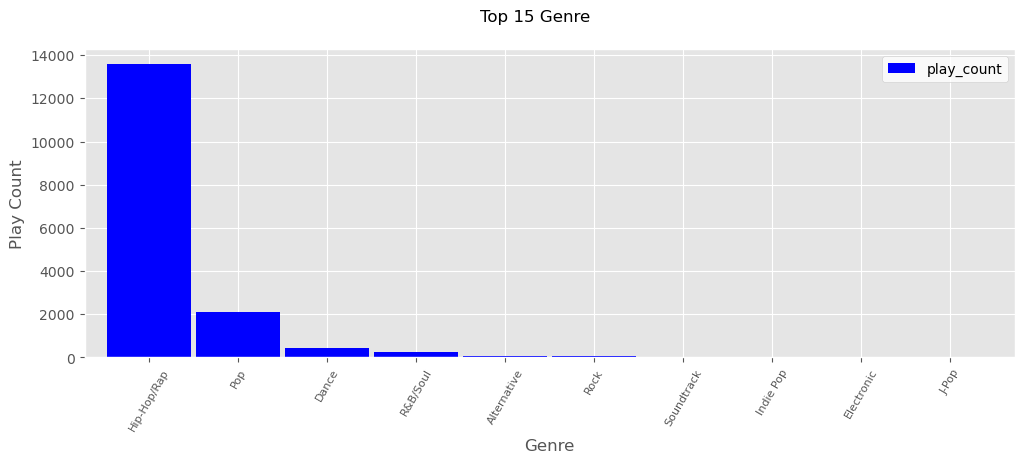

In [77]:
%matplotlib inline
plot_genre = plot_df(top10_genre, 'bar', 'genre', 'play_count', 'Genre', 'Play Count', 'blue', 'Top 15 Genre')

In [78]:
# Top 15 artists
df_artist_count = df_month.groupby('artist')['play_count'].sum().to_frame().reset_index()
top15_artist= df_artist_count.sort_values(by='play_count', ascending=False).head(15)

<Figure size 640x480 with 0 Axes>

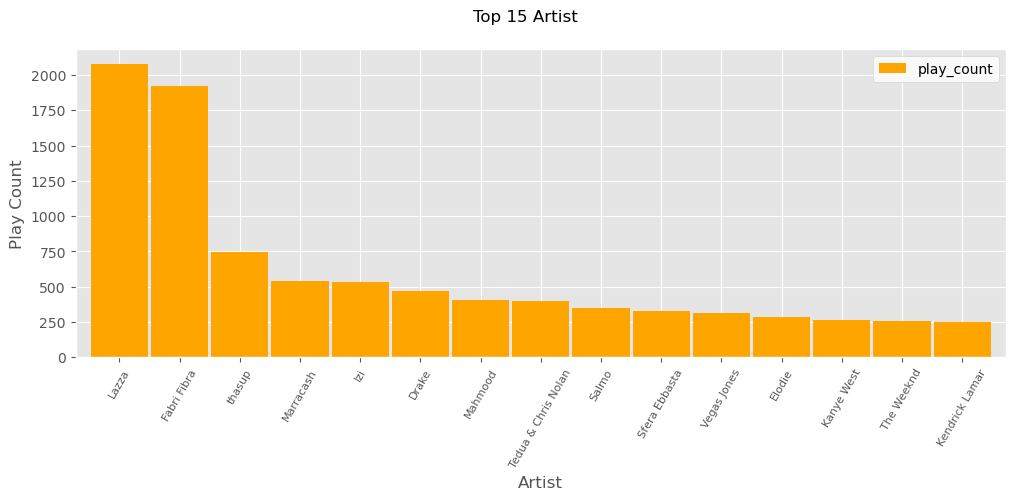

In [79]:
plot_artist = plot_df(top15_artist, 'bar', 'artist', 'play_count', 'Artist', 'Play Count', 'orange', 'Top 15 Artist')

<Figure size 640x480 with 0 Axes>

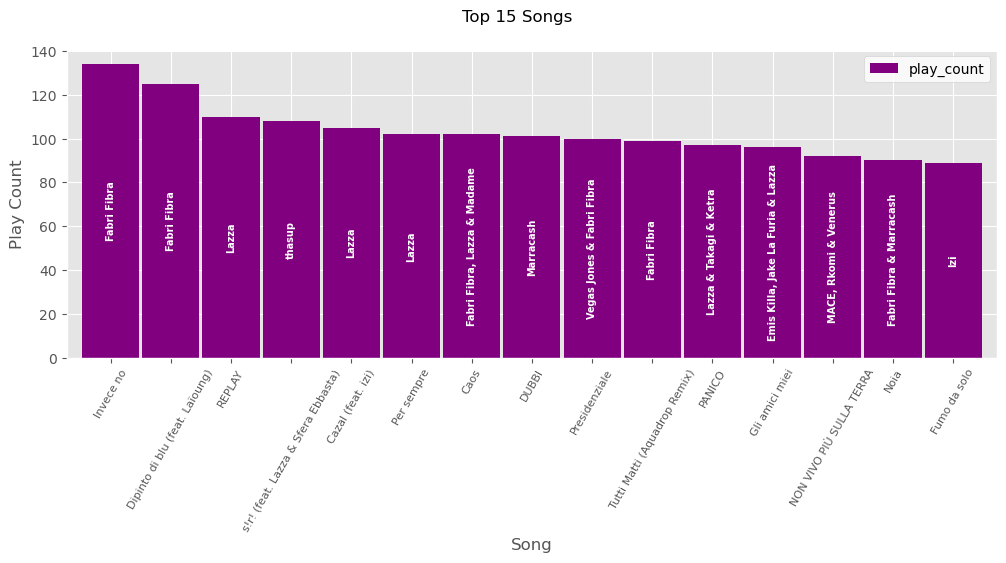

In [80]:
# Top 10 Songs 
top15_songs =  df_month[['song_name', 'artist', 'play_count']].sort_values(by='play_count', ascending=False)\
    .head(15)

plot_songs = plot_df(top15_songs, 'bar', 'song_name', 'play_count', 'Song', 'Play Count', 'purple', 'Top 15 Songs')

for i, pc in enumerate(top15_songs['play_count']):
    height = pc
    artist = top15_songs.iloc[i,1]
    plot_songs.text(x=i, y=height/2, s=str(artist), ha='center', va='center', 
                   rotation=90, fontsize=7, fontweight='bold', color='white')

<Figure size 640x480 with 0 Axes>

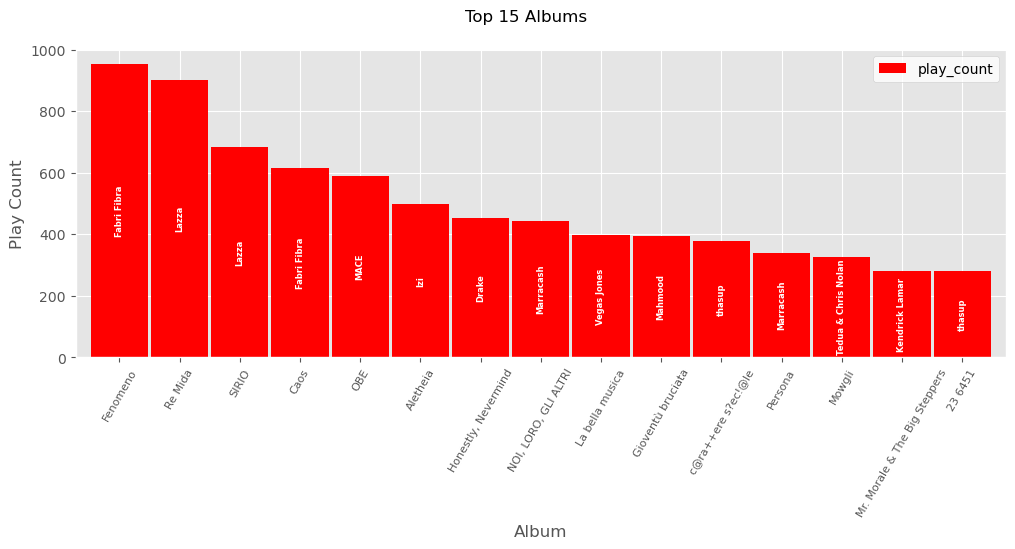

In [81]:
# Top 10 Albums
top15_albums =  df_month.groupby('album')['play_count'].sum().to_frame().reset_index()\
    .sort_values(by='play_count', ascending=False).head(15)

# Join with all_albums
top15_albums = top15_albums.merge(all_albums, on='album', how='left')

plot_albums = plot_df(top15_albums, 'bar', 'album', 'play_count', 'Album', 'Play Count', 'red', 'Top 15 Albums')

for i, pc in enumerate(top15_albums['play_count']):
    height = pc
    artist = top15_albums.iloc[i,2]
    plot_albums.text(x=i, y=height/2, s=str(artist), ha='center', va='center', 
                   rotation=90, fontsize=6, fontweight='bold', color='white')

### Other insightful KPI

In [103]:
# Find total number of songs per each artist
artist_songs = df_month.groupby('artist')['song_name'].nunique().to_frame().reset_index()

top10_artist_songs = artist_songs.sort_values(by='song_name', ascending=False).head(10)

# Find total number of songs
tot_songs = df_month['song_name'].nunique()
tot_songs_by_top10 = top10_artist_songs['song_name'].sum()

other_songs = tot_songs-tot_songs_by_top10
top10_artist_songs.loc[10] = ['Altri', other_songs]

display(top10_artist_songs)

,artist,song_name
135,Fabri Fibra,157
546,Salmo,72
188,Guè,69
373,Marracash,65
259,Kanye West,60
279,Lazza,57
178,Ghali,55
508,Rocco Hunt,54
237,Izi,47
158,Francesco Guccini,47


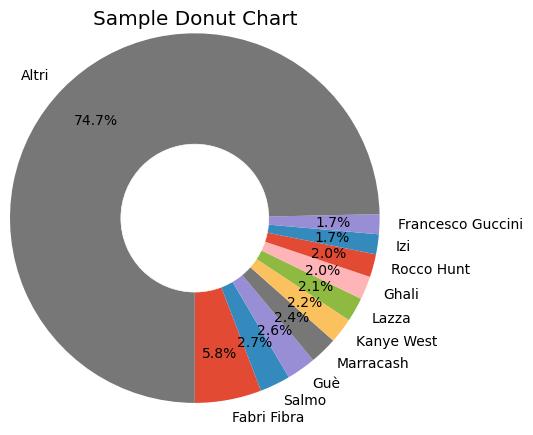

In [104]:
# Create a sample dataframe
data = {'label': ['A', 'B', 'C', 'D'],
        'value': [25, 20, 30, 15]}
df = pd.DataFrame(data)

# Create a donut chart
fig, ax = plt.subplots()

# Create the outer ring of the donut chart
wedges, texts, autotexts = ax.pie(top10_artist_songs['song_name'], labels=top10_artist_songs['artist'], autopct='%1.1f%%', startangle=-90, pctdistance=0.75, radius=1.25)

# Create the inner circle of the donut chart
circle = plt.Circle(xy=(0, 0), radius=0.5, color='white')
ax.add_artist(circle)

# Set the title
ax.set_title('Sample Donut Chart')

# Show the plot
plt.show()

In addition to the TOP charts considered above, let now turn our attention to other useful KPIs which can help us understanding better our music habits. First of all, can we quantify how much we listen to an artist in relation to the extent of its music library? To answer this question we can define the following quantity:

$$ 
\xi_A = \frac{\sum_{i, pc>=1}^{N} (pc)_i}{N}
$$

that is, we sum all the play counts ($pc$) generated by an artista $A$ and divide the result by the total number of songs of the artist. However, we restrict our attention just to those songs that we have listened at least one time ($pc>=1$). Let's code!

In [22]:
df_songs_played  = df_month[df_month['play_count']>=1]

df_pc_artist = df_songs_played.groupby('artist')['play_count'].sum().to_frame().reset_index()
df_total_songs_artist = df_songs_played.groupby('artist')['song_name'].nunique().to_frame().reset_index()
df_total_songs_artist = df_total_songs_artist.rename(columns={'song_name':'n_songs'})
df_total_songs_artist = df_total_songs_artist[df_total_songs_artist['n_songs']>1]

#display(df_pc_artist.sort_values(by='play_count', ascending=False).head(10))
#display(df_total_songs_artist.sort_values(by='n_songs', ascending=False).head(10))

In [23]:
# Join on Artist
df_join_xi = df_pc_artist.merge(df_total_songs_artist, on='artist', how='inner')
df_join_xi['xi'] = round(df_join_xi['play_count']/df_join_xi['n_songs'], 2)
top15_xi = df_join_xi.sort_values(by='xi', ascending=False).head(15)
display(top15_xi)

,artist,play_count,n_songs,xi
60,Marco Mengoni,113,2,56.50
25,"Emis Killa, Jake La Furia & Lazza",108,2,54.00
96,Taxi B,79,2,39.50
57,Mahmood,409,11,37.18
51,Lazza,2077,57,36.44
2,6ix9ine,113,4,28.25
105,thasup,747,28,26.68
91,Shiva,103,4,25.75
62,Marracash & Guè,97,4,24.25
20,Drake,467,21,22.24


,artist,song_name,play_count
1608,Marco Mengoni,Mi Fiderò (feat. Madame),71
219,"Emis Killa, Jake La Furia & Lazza",Gli amici miei,96
2204,Taxi B,PYPPARE,59
213,Mahmood,Il Nilo nel Naviglio,72
1865,Lazza,REPLAY,110
222,6ix9ine,GOOBA,57
2202,thasup,s!r! (feat. Lazza & Sfera Ebbasta),108
2509,Shiva,Vorrei (feat. Lazza),67
354,Marracash & Guè,∞ LOVE,60
2125,Drake,Tie That Binds,82


<Figure size 640x480 with 0 Axes>

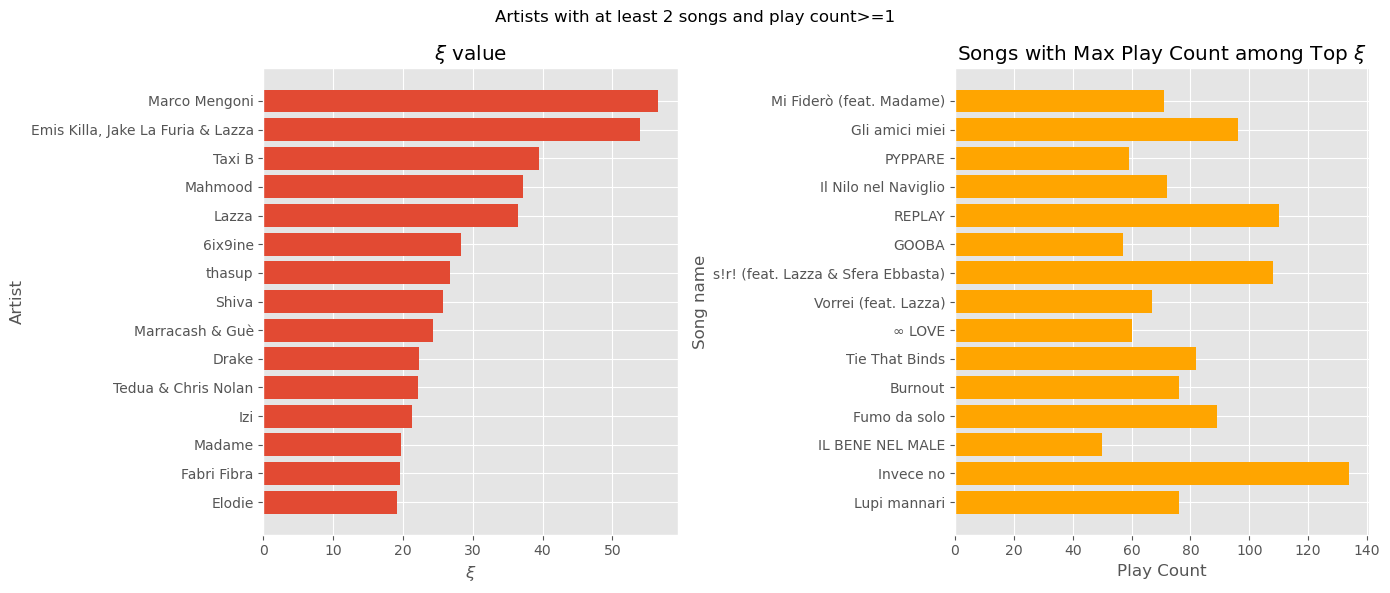

In [35]:
# Let also see what songs of the above artists have been streamed the most
artist_list = list(top15_xi['artist'])
df_artist_topxi = df_month[df_month['artist'].isin(artist_list)]
idx = df_artist_topxi.groupby('artist')['play_count'].idxmax()

df_songs_topxi = df_artist_topxi.loc[idx][['artist', 'song_name', 'play_count']]

df_songs_topxi['artist'] = pd.Categorical(df_songs_topxi['artist'], categories=artist_list, ordered=True)
df_songs_topxi = df_songs_topxi.sort_values(by='artist')
display(df_songs_topxi)


# Creating a bar plot
plt.clf()
    
# Define fig, ax
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
fig.suptitle('Artists with at least 2 songs and play count>=1')

# Make bar plot
ax1.barh(top15_xi['artist'], top15_xi['xi'])
ax1.set_xlabel(r'$\xi$')
ax1.set_ylabel('Artist')
ax1.set_yticks(top15_xi['artist'])
ax1.invert_yaxis()
ax1.set_title(r'$\xi$ value')

# Make the second bar plot
ax2.barh(df_songs_topxi['song_name'], df_songs_topxi['play_count'], color='orange')
ax2.set_xlabel('Play Count')
ax2.set_ylabel('Song name')
ax2.set_yticks(df_songs_topxi['song_name'])
ax2.invert_yaxis()
ax2.set_title(r'Songs with Max Play Count among Top $\xi$')

plt.tight_layout()

If we also include songs with a play count of zero, the situation may be significantly different. In this case, the corresponding $\xi$ value provides a more accurate measure of the degree to which an artist's song library is being "exploited". In addition, in the Apple Music Library, collaborative songs may be recorded as a distinct artist. In some cases, such a "new" artist may only be associated with few songs (maybe one or two), thus resulting in an increase in $\xi$. To avoid this, we may consider artists with at least 3 songs:

In [36]:
# Considering all songs:
df_pc_artist_full = df_month.groupby('artist')['play_count'].sum().to_frame().reset_index()
df_total_songs_artist_full = df_month.groupby('artist')['song_name'].nunique().to_frame().reset_index()
df_total_songs_artist_full = df_total_songs_artist_full.rename(columns={'song_name':'n_songs'})
df_total_songs_artist_full = df_total_songs_artist_full[df_total_songs_artist_full['n_songs']>=3]

# Join 
df_join_xi_full = df_pc_artist_full.merge(df_total_songs_artist_full, on='artist', how='inner')
df_join_xi_full['xi'] = round(df_join_xi_full['play_count']/df_join_xi_full['n_songs'], 2)
top15_xi_full = df_join_xi_full.sort_values(by='xi', ascending=False).head(15)

# Let also see what songs of the above artists have been streamed the most
artist_list_full = list(top15_xi_full['artist'])
df_artist_topxi_full = df_month[df_month['artist'].isin(artist_list_full)]
idx_full = df_artist_topxi_full.groupby('artist')['play_count'].idxmax()

df_songs_topxi_full = df_artist_topxi_full.loc[idx_full][['artist', 'song_name', 'play_count']]

df_songs_topxi_full['artist'] = pd.Categorical(df_songs_topxi_full['artist'], categories=artist_list_full, ordered=True)
df_songs_topxi_full = df_songs_topxi_full.sort_values(by='artist')

<Figure size 640x480 with 0 Axes>

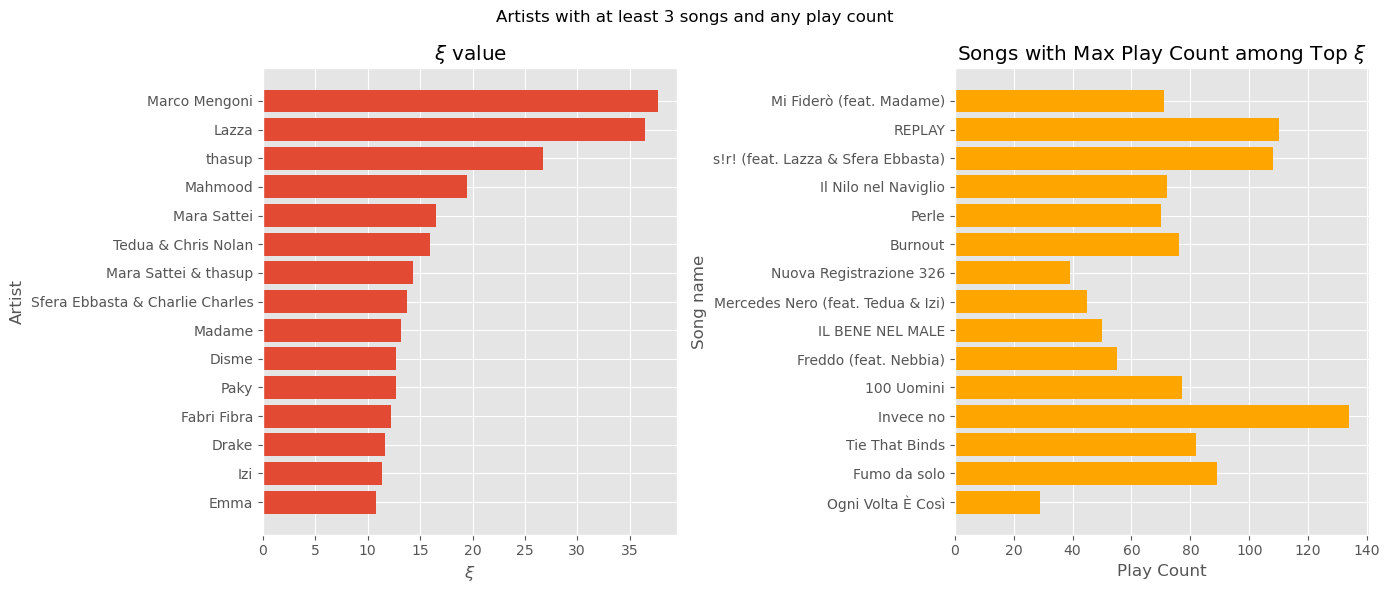

In [37]:
# Creating a bar plot
plt.clf()
    
# Define fig, ax
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
fig.suptitle('Artists with at least 3 songs and any play count')

# Make bar plot
ax1.barh(top15_xi_full['artist'], top15_xi_full['xi'])
ax1.set_xlabel(r'$\xi$')
ax1.set_ylabel('Artist')
ax1.set_yticks(top15_xi_full['artist'])
ax1.invert_yaxis()
ax1.set_title(r'$\xi$ value')

# Make the second bar plot
ax2.barh(df_songs_topxi_full['song_name'], df_songs_topxi_full['play_count'], color='orange')
ax2.set_xlabel('Play Count')
ax2.set_ylabel('Song name')
ax2.set_yticks(df_songs_topxi_full['song_name'])
ax2.invert_yaxis()
ax2.set_title(r'Songs with Max Play Count among Top $\xi$')

plt.tight_layout()